## 使用KL散度度量分层抽样和简单随机抽样下样本质量
#### 首经贸 22019212043 程义淇

### 1.数据准备

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import math

选出需要的字段；按“grade”字段准备分层抽样所用的抽样比例

In [2]:
data = pd.read_csv("loanStats3c.csv",encoding='ANSI',header=1)
#选出需要的字段
data_u=data[['id','grade','annual_inc']]
#删掉存在空值的行（删了两行）
data_u.dropna(axis=0, how='any', inplace=True)
#分层抽样，以分级作groupby
gbr = data_u.groupby("grade")
a=gbr.agg(np.size)
#用按比例的分层抽样，需要一个抽样比例的typicalFracDict,用前两列计数做
a["frac"] = a.id/sum(a.id)
a=a.reset_index()
b = a[["grade","frac"]]
fracdict = b.set_index('grade').T.to_dict("record")
typicalFracDict=fracdict[0]
typicalFracDict

B:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
B:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


{'A': 0.15324089988923265,
 'B': 0.2628496492367238,
 'C': 0.2824991830377415,
 'D': 0.18245631904392073,
 'E': 0.08539271481863438,
 'F': 0.026410161737307376,
 'G': 0.007151072236439487}

画出总体年收入的概率分布图

B:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


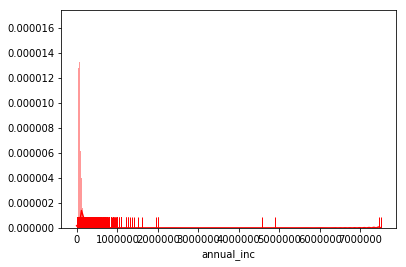

In [3]:
#画图。了解分布
sns.distplot(data_u.annual_inc,color="r",bins=1000,kde=True,hist=True,rug=True)

(0, 200000)

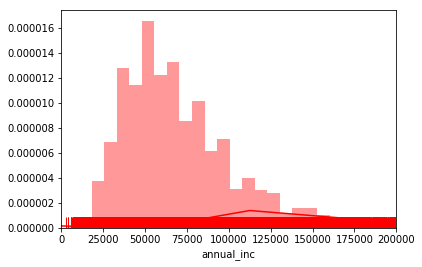

In [4]:
#可见有超多极端值，在20w之后频率极低，取年收入小于20w的看一下分布
#暂定分组为10w之前10000一组，10w-20w之间50 000一组，20w-40w之间100000一组，40w以上的一组
sns.distplot(data_u.annual_inc,color="r",bins=1000,kde=True,hist=True,rug=True)
plt.xlim(0,200000)

对年收入进行分组

In [5]:
# 划定分组的分界值
X_dot=[0]
for i in range(10000,110000,10000):
    X_dot.append(i)
X_dot.append(150000)
for i in range(200000,500000,100000):
    X_dot.append(i)
X_dot.append(max(data_u.annual_inc))

In [6]:
# 数据放入组中
X_group = pd.cut(data_u.annual_inc,bins=X_dot,right=True,retbins=False,include_lowest=False)

In [7]:
# 计算频数，利用groupby的方法
data=pd.DataFrame(data_u.annual_inc)
data["group"]=X_group
groupValueSize=data.groupby(X_group).size()
pinshulist_T=list(pd.DataFrame(groupValueSize).reset_index().iloc[:,1])

In [8]:
len(pinshulist_T)#有15个年收入分组

15

### 2.准备抽样函数

In [9]:
#抽样函数
#按比例分层抽样，将样本量当作参数传入，可调整
samplenum=list(np.trunc(2**np.array(np.arange(5,18,0.2))).astype(np.int32))
def typicalSampling(group, typicalFracDict,n):
    name = group.name
    return group.sample(frac=n/235629)

def get_sample_fc(samplenum):
    pinshulist_sam1=[]
    for i in  samplenum:
        result = list(data_u.groupby('grade', group_keys=False).apply(typicalSampling, typicalFracDict,i).annual_inc)
        pinshulist_sam1.append(result)
    return pinshulist_sam1
    
#简单随机抽样
def get_sample_jd(samplenum):
    pinshulist_sam2=[]
    for i in samplenum:
        result = list(data_u.sample(i).annual_inc)
        pinshulist_sam2.append(result)
    return pinshulist_sam2

In [11]:
len(samplenum),max(samplenum),len(data_u)

(65, 228209, 235629)

### 3.实施分层抽样（每个样本量下50次），并求样本和总体的交叉熵

In [12]:
#对抽样出来的数据分组求KL(分层)
def get_KL(get_sample_fc):
    pinshulist_fc_all=[]
    for i in get_sample_fc(samplenum):
        X_group = pd.cut(i,bins=X_dot,right=True,retbins=False,include_lowest=False)
        data=pd.DataFrame(i)
        data["group"]=X_group
        groupValueSize=data.groupby(X_group).size()
        pinshulist_fc=list(pd.DataFrame(groupValueSize).reset_index().iloc[:,1])
        pinshulist_fc_all.append(pinshulist_fc)
    #计算交叉熵
    shang_fc_l=[]
    for i in  pinshulist_fc_all:
        shang_fc = scipy.stats.entropy(pinshulist_T, i)
        shang_fc_l.append(shang_fc)    
    return shang_fc_l

In [13]:
#每个样本量下抽取50次(分层)
i=0
#pinshulist_fc_all_meanpre=[]
shang_fc_l_meanpre=[]
while i < 50:
    get_sample_fc(samplenum)
    get_KL(get_sample_fc)
    #pinshulist_fc_all_meanpre.append(pinshulist_fc_all)
    shang_fc_l_meanpre.append(get_KL(get_sample_fc))
    i=i+1

In [14]:
t_0=np.array(shang_fc_l_meanpre)
arr_ini=np.zeros(65)
for i in np.arange(50):
    arr = (arr_ini+t_0[i])/50

In [15]:
len(samplenum),len(shang_fc_l_meanpre[0]),len(arr)

(65, 65, 65)

In [16]:
arr

array([           inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf, 1.51806131e-04,            inf,
       2.25216786e-05, 5.70409885e-05, 4.56618287e-05, 4.54820776e-05,
       3.00681507e-05,            inf, 3.33495717e-05, 4.05357942e-05,
       2.38188350e-05, 2.15568528e-05, 2.16385763e-05, 1.82072328e-05,
       1.15789972e-05, 7.71353122e-06, 1.19098747e-05, 1.86752435e-05,
      

(0, 0.0001)

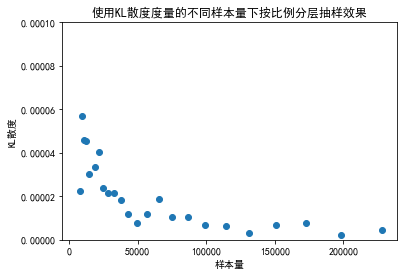

In [26]:
#画图
#按不同样本量抽样次，画图y是交叉熵的值,x是样本量
plt.scatter(samplenum,arr)
plt.xlabel('样本量')
plt.ylabel('KL散度')
plt.title('使用KL散度度量的不同样本量下按比例分层抽样效果')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.ylim(0,0.0001)

In [18]:
arr

array([           inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf, 1.51806131e-04,            inf,
       2.25216786e-05, 5.70409885e-05, 4.56618287e-05, 4.54820776e-05,
       3.00681507e-05,            inf, 3.33495717e-05, 4.05357942e-05,
       2.38188350e-05, 2.15568528e-05, 2.16385763e-05, 1.82072328e-05,
       1.15789972e-05, 7.71353122e-06, 1.19098747e-05, 1.86752435e-05,
      

In [27]:
samplenum[38]

6208

### 3.实施简单随机抽样（每个样本量下50次），并求样本和总体的交叉熵# 

In [19]:
#简单随机
def get_KL(get_sample_jd):
    pinshulist_jd_all=[]
    for i in get_sample_jd(samplenum):
        X_group = pd.cut(i,bins=X_dot,right=True,retbins=False,include_lowest=False)
        data=pd.DataFrame(i)
        data["group"]=X_group
        groupValueSize=data.groupby(X_group).size()
        pinshulist_jd=list(pd.DataFrame(groupValueSize).reset_index().iloc[:,1])
        pinshulist_jd_all.append(pinshulist_jd)    
     #计算交叉熵
    shang_jd_l=[]
    for i in  pinshulist_jd_all:
        shang_jd = scipy.stats.entropy(pinshulist_T, i)
        shang_jd_l.append(shang_jd)
    return shang_jd_l

In [20]:
i=0
#pinshulist_jd_all_meanpre=[]
shang_jd_l_meanpre=[]
while i < 50:
    get_sample_fc(samplenum)
    get_KL(get_sample_jd)
    #pinshulist_jd_all_meanpre.append(pinshulist_jd_all)
    shang_jd_l_meanpre.append(get_KL(get_sample_jd))
    i=i+1

In [21]:
j_0=np.array(shang_jd_l_meanpre)
arr_ini=np.zeros(65)
for i in np.arange(50):
    arr1 = (arr_ini+j_0[i])/50

(0, 0.0001)

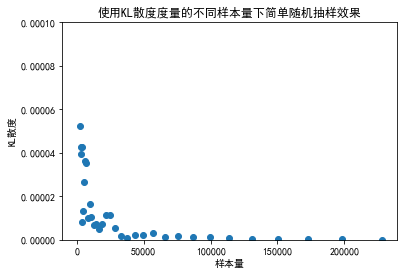

In [24]:
plt.scatter(samplenum,arr1)
plt.xlabel('样本量')
plt.ylabel('KL散度')
plt.title('使用KL散度度量的不同样本量下简单随机抽样效果')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.ylim(0,0.0001)

In [23]:
arr1

array([           inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
       2.27578357e-04,            inf,            inf,            inf,
       2.13477595e-04,            inf, 1.14992127e-04, 1.57462610e-04,
       1.10599215e-04,            inf, 5.21772670e-05,            inf,
       3.92994020e-05, 4.23944107e-05, 4.24243584e-05, 8.23654892e-06,
       1.33185198e-05, 2.66151760e-05, 3.61606661e-05, 3.52905062e-05,
       1.00058211e-05, 1.62288466e-05, 1.02892160e-05, 6.80291928e-06,
       7.23659840e-06, 4.78940203e-06, 6.97030431e-06, 1.12446297e-05,
       1.13737128e-05, 5.46242802e-06, 1.83153805e-06, 8.90353411e-07,
       2.33183610e-06, 2.00138477e-06, 3.18651733e-06, 1.06882196e-06,
      

In [28]:
samplenum[21]

588

注：相对熵（relative entropy），又被称为Kullback-Leibler散度（Kullback-Leibler divergence）或信息散度（information divergence），是两个概率分布（probability distribution）间差异的非对称性度量，在信息论中相对熵等价于两个概率分布的信息熵（Shannon entropy）的差值。故该值越小表示两个分布越接近，即抽样效果越好

此例中分层抽样略优于简单随机抽样，以KL散度达到e-04的水平作为衡量标准，则按比例分层抽样需要的样本量为1024，简单随机抽样需要的样本量为1341